# Examining Effect of Class of Device Filtering on the Baseline

The [bluetooth_baselines](bluetooth_baselines.ipynb) notebook identified route closures as contributing to spikes in travel times, because pedestrian devices were being detected by the sensors. This leads one to question whether the presence of pedestrian devices elsewhere might be affecting results elsewhere.

This notebook asks and answers the following questions:
1. [Can the spike](#Nuit Blanche) in travel times during a street closure such as Nuit Blanche can be used as evidence for which devices are pedestrians and which are cars?
2. [Do the proportions](#Device-type-Proportions) of device types change by month?
3. [Do speed distributions}(#Speed-Distributions-by-Device-Type) vary by month and by device type? 
4. [How does the Pilot's restrictions](#Device-Types-on-King) affect the number of observations by device type on King Street itself?

## Conclusions

 1. Based on an analysis of speed distributions, `cod = 0` devices appear to be vehicles.
 2. Cellular and Smart phone device types have noticeably slower speed distributions, but they contain significant 
 3. Very short Blip segments have a similar "teleporting" problem, where short detection intervals between sensors result in impossibly fast travel times. Even when aggregated to 5-min bins, these observations appear a non-trivial amount of times, and not only in off-peak times.
 4. Speeds do not meaningfully change pre-post pilot
 4. Proportions of device types overall do not change in the King Pilot routes month-by-month

In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read('../../db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## Nuit Blanche
We will first look at Nuit Blanche as an example, since the Nuit Blanche street closure of Queen affected travel times from Yonge to University overnight from Sep 30th to Oct 1st, we may see noticeable trends in terms of device types.

In [13]:
sql = ''' WITH nuit_blanche AS(SELECT cod, device_class FROM bluetooth.observations_201709 
WHERE measured_timestamp > '2017-09-30 19:00' AND analysis_id = 1453719
UNION ALL
SELECT cod, device_class FROM bluetooth.observations_201710 
WHERE measured_timestamp < '2017-10-01 03:00' AND analysis_id = 1453719
)
, nb_total AS (SELECT COUNT(1) as total FROM nuit_blanche  WHERE device_class = 1)
, queen_total AS(SELECT COUNT(1) AS total FROM bluetooth.observations_201709 
WHERE analysis_id = 1453719 AND device_class = 1)
SELECT nb.total AS "Nuit Blanche Observations (No WiFi)",
q.total AS "September Queen Observations  (No WiFi)"
FROM nb_total nb, queen_total q
'''
print_table(sql, con)

Nuit Blanche Observations (No WiFi),September Queen Observations (No WiFi)
135,4627


In [11]:
sql = ''' WITH nuit_blanche AS(SELECT cod, device_class FROM bluetooth.observations_201709 
WHERE measured_timestamp > '2017-09-30 19:00' AND analysis_id = 1453719
UNION ALL
SELECT cod, device_class FROM bluetooth.observations_201710 
WHERE measured_timestamp < '2017-10-01 03:00' AND analysis_id = 1453719
)
, nb_total AS (SELECT COUNT(1) as total FROM nuit_blanche WHERE device_class = 1 )
, nb_counts AS (SELECT cod, device_type, count(1) AS nb_cnt, to_char(100.0*COUNT(1)/total, '99.9%') AS "Proportion of Observations (Nuit Blanche)"
FROM nuit_blanche
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN nb_total
WHERE device_class = 1
GROUP BY cod, device_type, total
ORDER BY "Proportion of Observations (Nuit Blanche)"

)
, queen_total AS(SELECT COUNT(1) AS total FROM bluetooth.observations_201709 
WHERE analysis_id = 1453719 AND device_class = 1)
, queen_counts  AS (SELECT cod, device_type, count(1) AS queen_cnt, to_char(100.0*COUNT(1)/total, '99.9%') AS "Proportion of Observations (September)"
FROM bluetooth.observations_201709
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN queen_total
WHERE analysis_id = 1453719 AND device_class = 1
GROUP BY cod, device_type, total
)

SELECT cod, device_type as "Device Type", "Proportion of Observations (Nuit Blanche)", "Proportion of Observations (September)"
FROM queen_counts
INNER JOIN nb_counts USING (cod, device_type)
ORDER BY nb_cnt DESC
LIMIT 15
'''

print_table(sql, con)

cod,Device Type,Proportion of Observations (Nuit Blanche),Proportion of Observations (September)
5898764,Smart phone,45.2%,17.3%
7995916,Smart phone,15.6%,11.6%
2098184,Hands-free Device,11.9%,17.7%
3408904,Hands-free Device,8.1%,16.4%
5898756,Cellular,4.4%,4.9%
5767684,Cellular,3.0%,2.6%
2098180,Wearable Headset Device,1.5%,.7%
7936,none,1.5%,1.9%
2360324,Wearable Headset Device,1.5%,5.0%
3146760,Hands-free Device,1.5%,3.4%


It's odd that the proportion of smartphones shifts between the two sampling periods. 

According to [this Toronto Star Article](https://www.thestar.com/news/gta/2017/09/30/list-of-weekend-road-closures-due-to-nuit-blanche-invictus-games.html), Queen St. was closed from 18:30 until 08:00 the next day. So it is odd that `Hands-free Device` that have previously been reliably identified as exclusively car show up in this timeperiod. Given the sample of ~100 this was around 20 devices  over the 10 hour period.

If one ignores the `device_class` filter, the vendor's identification of whether a device is WiFi or not. The table looks as below.

In [12]:
sql = ''' WITH nuit_blanche AS(SELECT cod, device_class FROM bluetooth.observations_201709 
WHERE measured_timestamp > '2017-09-30 19:00' AND analysis_id = 1453719
UNION ALL
SELECT cod, device_class FROM bluetooth.observations_201710 
WHERE measured_timestamp < '2017-10-01 03:00' AND analysis_id = 1453719
)
, nb_total AS (SELECT COUNT(1) as total FROM nuit_blanche  )
, nb_counts AS (SELECT cod, device_type, count(1) AS nb_cnt, to_char(100.0*COUNT(1)/total, '99.9%') AS "Proportion of Observations (Nuit Blanche)"
FROM nuit_blanche
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN nb_total
GROUP BY cod, device_type, total
ORDER BY "Proportion of Observations (Nuit Blanche)"

)
, queen_total AS(SELECT COUNT(1) AS total FROM bluetooth.observations_201709 
WHERE analysis_id = 1453719)
, queen_counts  AS (SELECT cod, device_type, count(1) AS queen_cnt, to_char(100.0*COUNT(1)/total, '99.9%') AS "Proportion of Observations (September)"
FROM bluetooth.observations_201709
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN queen_total
WHERE analysis_id = 1453719
GROUP BY cod, device_type, total
)

SELECT cod, device_type as "Device Type", "Proportion of Observations (Nuit Blanche)", "Proportion of Observations (September)"
FROM queen_counts
INNER JOIN nb_counts USING (cod, device_type)
ORDER BY nb_cnt DESC
LIMIT 15
'''

print_table(sql, con)

cod,Device Type,Proportion of Observations (Nuit Blanche),Proportion of Observations (September)
0,WiFi,96.1%,88.5%
5898764,Smart phone,1.8%,2.1%
7995916,Smart phone,.6%,1.4%
2098184,Hands-free Device,.5%,2.1%
3408904,Hands-free Device,.3%,2.0%
5898756,Cellular,.2%,.6%
5767684,Cellular,.1%,.3%
7936,none,.1%,.2%
2360324,Wearable Headset Device,.1%,.6%
3146760,Hands-free Device,.1%,.4%


In [8]:
sql = '''WITH nuit_blanche AS(SELECT cod, measured_timestamp, measured_time FROM bluetooth.observations_201709 
WHERE measured_timestamp > '2017-09-30 5:30' AND analysis_id = 1453719 AND outlier_level = 0
UNION ALL
SELECT cod, measured_timestamp, measured_time FROM bluetooth.observations_201710 
WHERE measured_timestamp < '2017-10-01 21:00' AND analysis_id = 1453719 AND outlier_level = 0)

SELECT measured_timestamp, measured_time, device_type
FROM nuit_blanche
INNER JOIN bluetooth.class_of_device USING (cod)
WHERE device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone') AND cod > 0  
'''

nuit_blanche = pandasql.read_sql(sql, con)

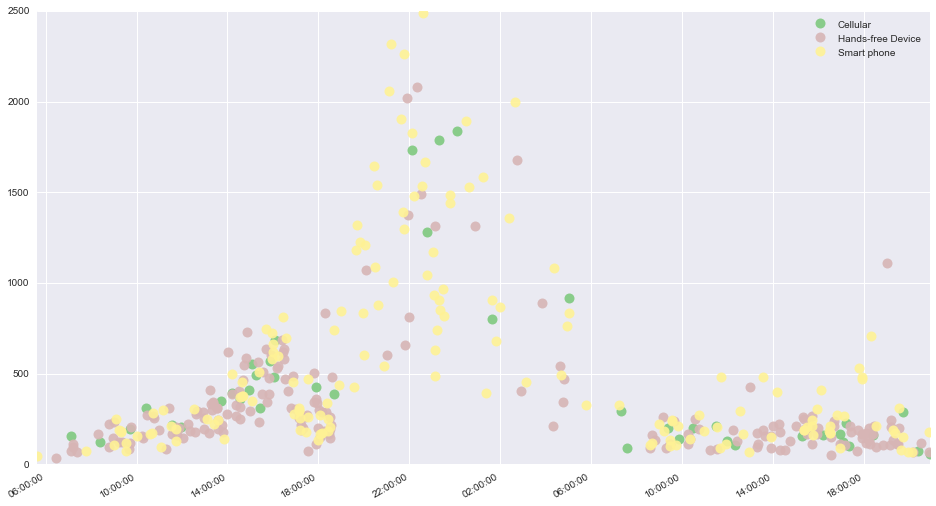

In [9]:
NUM_COLORS = 3
groups = nuit_blanche.groupby('device_type')

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 5
cm = plt.get_cmap('Accent')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for i, (device_type, data) in enumerate(groups):
    ax.plot(data.measured_timestamp, data.measured_time, marker='o', markersize=10,
            alpha=0.9, linestyle='', label=device_type, color=colors[i])
ax.legend()
plt.gcf().autofmt_xdate()

The chart above is **inconclusive**. Observations are all over the place between 18:30 and 08:00 when the street was closed to traffic. It excludes the 96% of observations from WiFi devices.
Google Maps gives the minimum walking time from University to Yonge on Queen St. as **420 seconds**, which is below every observation in that time period. 
We can see right before 18:30 a cluster of Hands-free and Smart phone observations closer to the **120 seconds** driving time according to Maps.

In [ ]:
sql = ''' SELECT user_id, route_name, measured_timestamp, measured_time/ 60
FROM bluetooth.observations_201709 
INNER JOIN (SELECT cod, user_id FROM bluetooth.observations_201709 
INNER JOIN bluetooth.class_of_device USING (cod)
WHERE measured_timestamp > '2017-09-30 18:30' AND analysis_id IN (1453719, 1453627) AND device_type = 'Hands-free Device') hfd USING (cod, user_id)
INNER JOIN bluetooth.all_analyses USING (analysis_id)
WHERE measured_timestamp > '2017-09-30 18:30'
ORDER BY user_id, measured_timestamp'''

## Device type & speed distributions


We discovered a significant portion of Bluetooth observations have a `cod = 0`, investigating the impact these have on speed distributions.

### Device type Proportions

In [9]:
sql = '''WITH three_months AS (SELECT 'October' AS mnth, cod
FROM bluetooth.observations_201710
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN (SELECT DISTINCT bt_id FROM king_pilot.date_baseline ) bt_ids  USING (bt_id) 
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6
UNION ALL
SELECT 'November', cod
FROM bluetooth.observations_201711
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN (SELECT DISTINCT bt_id FROM king_pilot.date_baseline ) bt_ids  USING (bt_id) 
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6
UNION ALL
SELECT 'December', cod
FROM bluetooth.observations_201712
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN (SELECT DISTINCT bt_id FROM king_pilot.date_baseline ) bt_ids  USING (bt_id) 
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6
)
, cnts AS(SELECT mnth as "Month", device_type AS "Device Type", COUNT(1) AS "Num observations"
FROM three_months 
INNER JOIN bluetooth.class_of_device USING (cod)
GROUP BY "Month", device_type)
, tot AS (SELECT "Month", SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY "Month")
SELECT tot."Month", "Device Type", 100.0*COALESCE(SUM("Num observations") OVER w, 0.0)/total_cnt as bottom, 
100.0*"Num observations"/total_cnt as "% of Observations"
FROM tot
JOIN LATERAL (SELECT "Month", "Device Type", "Num observations" 
              FROM cnts c 
              WHERE tot."Month" = c."Month"
              ORDER BY "Num observations" DESC LIMIT 8
        )top_8 ON TRUE
WINDOW w AS (PARTITION BY tot."Month" ORDER BY "Num observations" DESC ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
'''
three_month_device_type_king = pandasql.read_sql(sql, con)

In [10]:
three_month_device_type_king.sort_values('Month', inplace=True, ascending=False)

In [11]:
months = range(0,len(three_month_device_type_king["Month"].unique()))
NUM_COLORS = 8
cm = plt.get_cmap('Paired')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

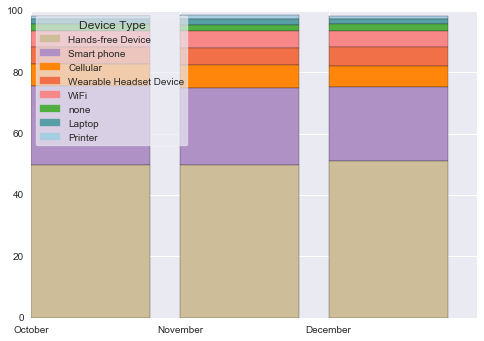

In [12]:
handles = []

for i, device_type in enumerate(three_month_device_type_king["Device Type"].unique()):
    device_data = three_month_device_type_king[three_month_device_type_king["Device Type"] == device_type]
    plt.bar(months, device_data["% of Observations"], bottom=device_data.bottom, color=colors[i])
    handles.append(mpl.patches.Patch(color=colors[i], label=device_type))
plt.xticks(months, three_month_device_type_king["Month"].unique())
plt.legend(title="Device Type", handles=list(reversed(handles)), loc='upper left',
                 fancybox=True, framealpha=0.7, frameon=True)
# plt.show()    

It doesn't seem like the proportions change too much from month to month 

In [13]:
sql = '''WITH three_months AS (SELECT 'October' AS mnth, cod
FROM bluetooth.observations_201710
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN (SELECT DISTINCT bt_id FROM king_pilot.date_baseline ) bt_ids  USING (bt_id) 
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6
UNION ALL
SELECT 'November', cod
FROM bluetooth.observations_201711
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN (SELECT DISTINCT bt_id FROM king_pilot.date_baseline ) bt_ids  USING (bt_id) 
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6
UNION ALL
SELECT 'December', cod
FROM bluetooth.observations_201712
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN (SELECT DISTINCT bt_id FROM king_pilot.date_baseline ) bt_ids  USING (bt_id) 
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6
)
, cnts AS(SELECT mnth as "Month", device_type AS "Device Type", COUNT(1) AS "Num observations"
FROM three_months 
INNER JOIN bluetooth.class_of_device USING (cod)
GROUP BY "Month", device_type)
, tot AS (SELECT "Month", SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY "Month")
SELECT tot."Month", "Device Type", 100.0*"Num observations" /total_cnt as "% of Observations"
FROM tot
JOIN LATERAL (SELECT "Month", "Device Type", "Num observations" 
              FROM cnts c 
              WHERE tot."Month" = c."Month"
              ORDER BY "Num observations" DESC LIMIT 8
        )top_8 ON TRUE
'''
device_type_to_pivot = pandasql.read_sql(sql, con)

In [16]:
device_type_to_pivot.pivot_table(values="% of Observations", index='Device Type', columns='Month')[['October','November','December']].sort_values('October', ascending=False)

Month,October,November,December
Device Type,,,
Hands-free Device,49.736681,49.681277,50.942338
Smart phone,25.694722,25.202892,24.111992
Cellular,7.240598,7.365002,7.080152
Wearable Headset Device,5.695835,5.742583,6.201461
WiFi,5.223913,5.381045,5.123254
none,2.033863,2.172661,2.214289
Laptop,1.789870,1.820700,1.728033
Printer,1.025123,1.142512,1.013735


The proportions for the 8 most common device types do not seem to change _much_ over the three months, though there is  a slow decrease in `Smart phone` and a slow increase in `Hands-free Device`

### Speed Distributions by Device Type

In [30]:
sql = '''WITH three_months AS (SELECT 'October' AS mnth, cod, analysis_id, measured_time
FROM bluetooth.observations_201710
INNER JOIN king_pilot.bt_segments USING (analysis_id)
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6 AND  outlier_level = 0
UNION ALL
SELECT 'November', cod,analysis_id, measured_time
FROM bluetooth.observations_201711
INNER JOIN king_pilot.bt_segments USING (analysis_id)
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6 AND  outlier_level = 0
UNION ALL
SELECT 'December', cod,analysis_id, measured_time
FROM bluetooth.observations_201712
INNER JOIN king_pilot.bt_segments USING (analysis_id)
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6 AND  outlier_level = 0
)

SELECT analysis_id, mnth, CASE WHEN device_type = 'WiFi' THEN 'cod=0' ELSE device_type END AS device_type, 3.6 * length/measured_time  AS "Speed"
FROM three_months
INNER JOIN bluetooth.segments USING (analysis_id)
INNER JOIN bluetooth.class_of_device USING (cod)
WHERE device_type IN ('WiFi','Hands-free Device', 'Wearable Headset Device', 'Cellular', 'Smart phone')
AND measured_time > 0
'''

speed_three_months = pandasql.read_sql(sql, con)

In [31]:
speed_three_months.to_pickle('speed_three_months.pkl')

In [3]:
speed_three_months = pd.read_pickle('speed_three_months.pkl')

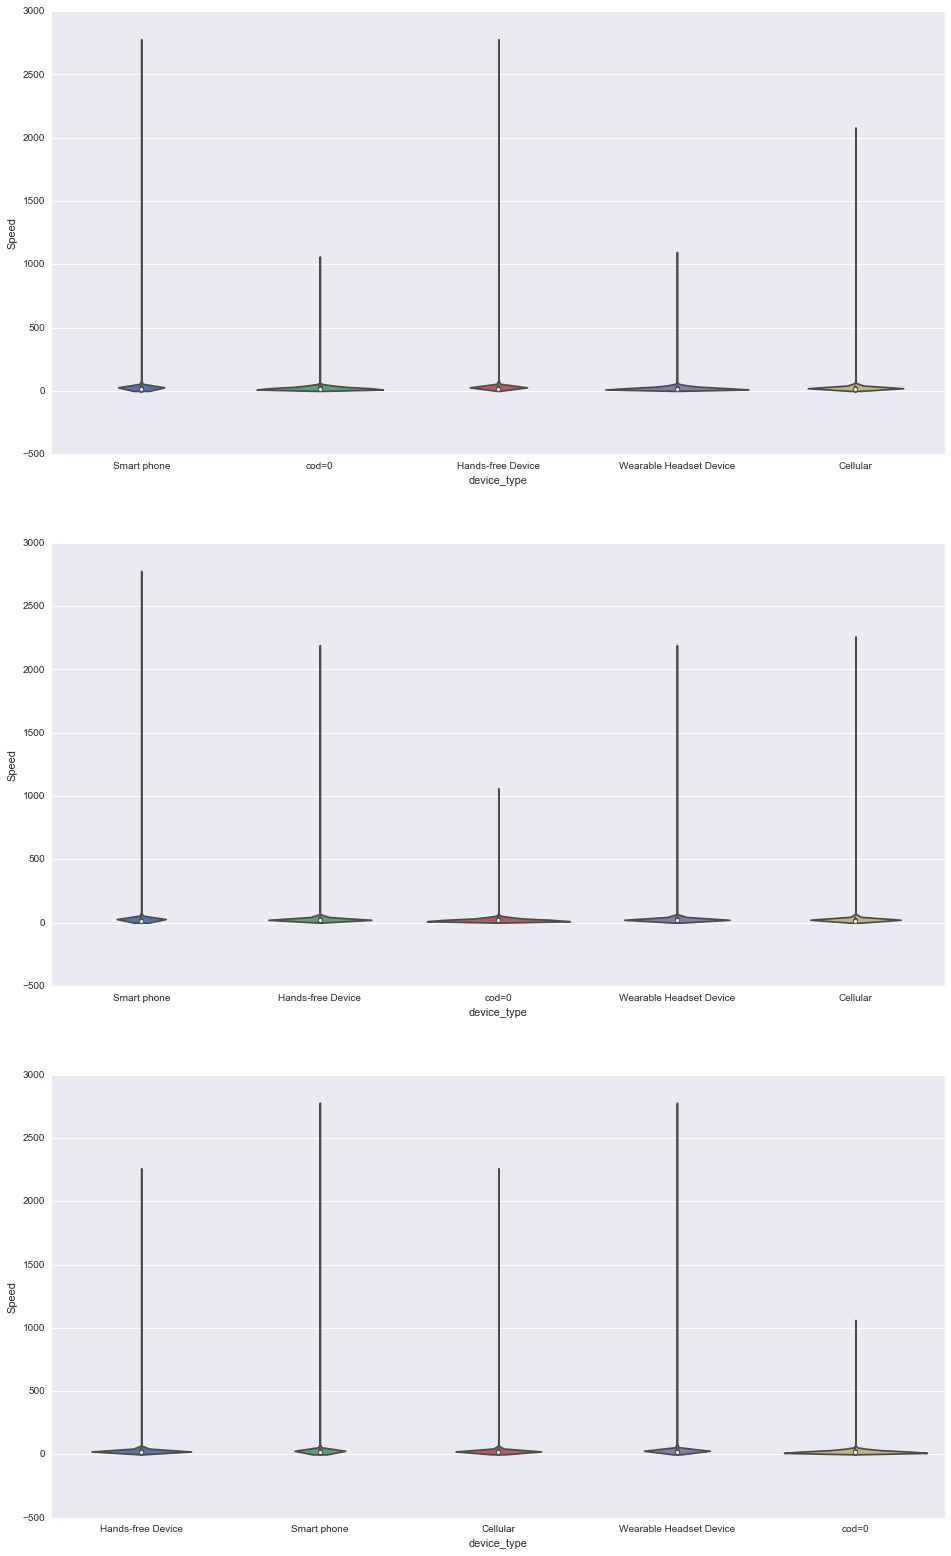

In [32]:
fig, axes = plt.subplots(3,1, figsize=(16,27))

for i, month in enumerate(speed_three_months.mnth.unique()):
    sns.violinplot(x='device_type', y='Speed', 
                        data=speed_three_months[speed_three_months.mnth == month],
                        title = month, ylim=[0,70], cut=0,
                        ax=axes[i])

In [13]:
speed_three_months[speed_three_months['Speed'] > 100].groupby('analysis_id').count().sort_values('mnth', ascending=False).head(10)

,mnth,device_type,Speed
analysis_id,,,
1455710,987,987,987
1455628,324,324,324
1455641,271,271,271
1453867,238,238,238
1455724,150,150,150
1455538,136,136,136
1455525,111,111,111
1454646,95,95,95
1454508,91,91,91


In [14]:
obs_over_100 = len(speed_three_months[speed_three_months['Speed'] > 100])
total_obs = len(speed_three_months)
print("Proportion of observations over 100 km/hr: ", 100.0*obs_over_100/total_obs, "%")

Proportion of observations over 100 km/hr:  0.11330600186785508 %


Recreating the above graphic with speeds filtered below 100 km/hr

In [33]:
speed_three_months.sort_values(["mnth", 'device_type'], ascending=[False, True], inplace=True)

In [28]:
speed_three_months.loc[speed_three_months['device_type'] == 'WiFi', 'device_type'] = "cod = 0"

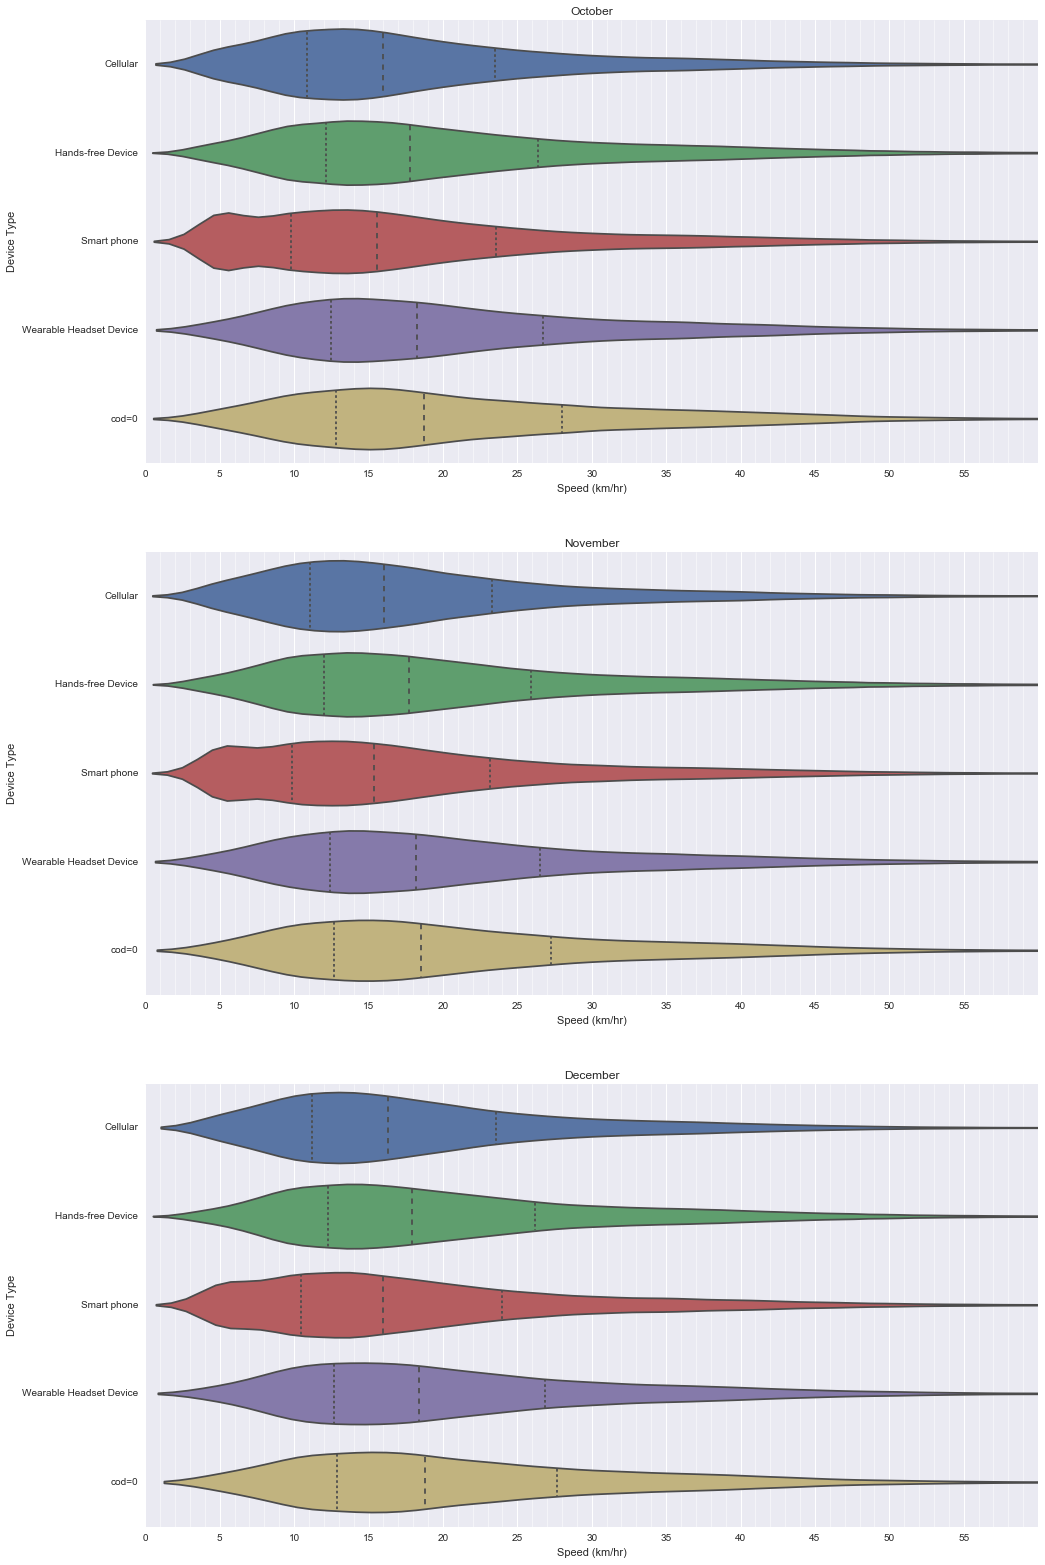

In [42]:
fig, axes = plt.subplots(3,1, figsize=(16,27))

for i, month in enumerate(speed_three_months.mnth.unique()):
    sns.violinplot(y='device_type', x='Speed', 
                        data=speed_three_months[(speed_three_months.mnth == month) &
                                                (speed_three_months['Speed'] < 100)],
                       inner="quartile", orient='h',
                       ax=axes[i], cut=0)
    axes[i].set_title(month)
    axes[i].set_xlim([0,60])
    axes[i].set_xlabel("Speed (km/hr)")
    axes[i].set_ylabel("Device Type")
    axes[i].set_xticks(range(0,60,5))
    axes[i].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axes[i].grid(b=True, which='minor', color='w', linewidth=0.5)

Some interesting findings from the plots above:
 1. Devices with `cod=0` have the fastest speed distribution, implying that these devices are **definitely vehicles**
 2. Cellular and Smart phone devices have a noticeably slower speed distribution, with medians (dashed line) about 2km/hr slower than Hands-free Device or Wearable Headset Device.
 3. Smart phone has a noticeable bimodal distribution, with the second mode near 5-6km/hr: walking speed. Even though 25% of observations are below 10 km/hr
 4. There is no noticeable difference in the speed distributions by month 
 
To confirm #4, showing the distributions from above separated by being pre-post pilot for weekdays only. Speeds will be different from the above graphs because a subset of the routes in `king_pilot.bt_segments` were used in the baseline.

In [54]:
sql = '''WITH three_months AS (SELECT 'Baseline' as period, cod, analysis_id, measured_time
FROM bluetooth.observations_201710
INNER JOIN king_pilot.bt_segments seg USING (analysis_id)
INNER JOIN king_pilot.date_baseline baseline ON seg.bt_id = baseline.bt_id AND measured_timestamp::DATE = dt
WHERE day_type = 'Weekday' AND street_name != 'King' AND device_class = 1 AND  outlier_level = 0
UNION ALL
SELECT CASE WHEN day_type IS NOT NULL THEN 'Baseline' ELSE 'Pilot' END AS period, cod,analysis_id, measured_time
FROM bluetooth.observations_201711
INNER JOIN king_pilot.bt_segments seg USING (analysis_id)
INNER JOIN (SELECT DISTINCT bt_id FROM king_pilot.date_baseline ) bt_ids  USING (bt_id) 
LEFT OUTER JOIN king_pilot.date_baseline baseline ON bt_ids.bt_id = baseline.bt_id AND measured_timestamp::DATE = dt
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6 AND  outlier_level = 0
UNION ALL
SELECT 'Pilot', cod, analysis_id, measured_time
FROM bluetooth.observations_201712
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN (SELECT DISTINCT bt_id FROM king_pilot.date_baseline ) baseline  USING (bt_id) 
WHERE street_name != 'King' AND device_class = 1 AND EXTRACT('isodow' FROM measured_timestamp) < 6 AND  outlier_level = 0
)

SELECT analysis_id, period, CASE WHEN device_type = 'WiFi' THEN 'cod=0' ELSE device_type END AS device_type, 3.6 * length/measured_time  AS "Speed"
FROM three_months
INNER JOIN bluetooth.segments USING (analysis_id)
INNER JOIN bluetooth.class_of_device USING (cod)
WHERE device_type IN ('WiFi','Hands-free Device', 'Wearable Headset Device', 'Cellular', 'Smart phone')
AND measured_time > 0 AND 3.6 * length/measured_time < 100

'''

device_distro_pilot = pandasql.read_sql(sql, con)

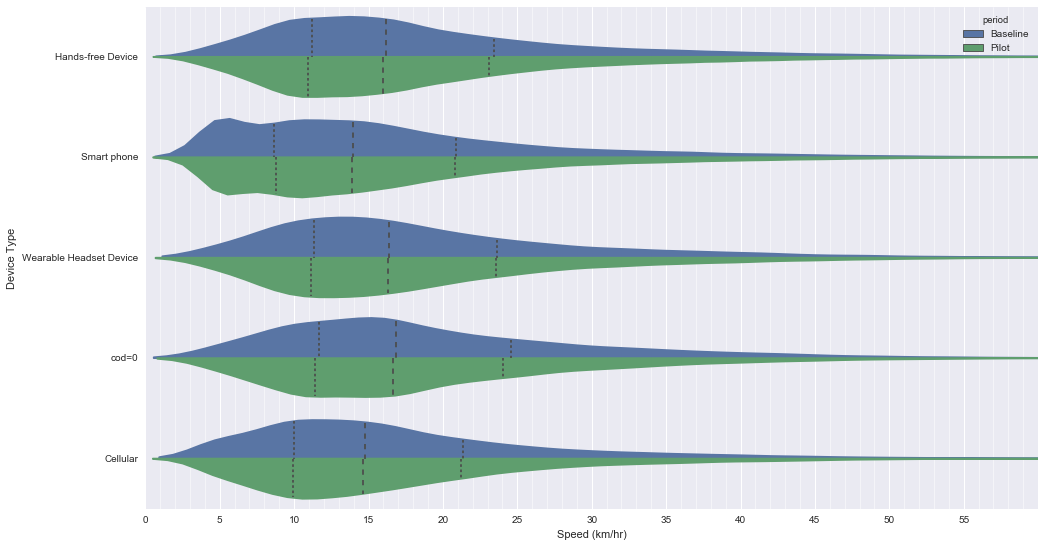

In [55]:
fig, ax = plt.subplots(1,1, figsize=(16,9))

sns.violinplot(y='device_type', x='Speed', hue='period', split= True,
                    data=device_distro_pilot,
                   inner="quartile", orient='h',
                   ax=ax, cut=0)
ax.set_xlim([0,60])
ax.set_xlabel("Speed (km/hr)")
ax.set_ylabel("Device Type")
ax.set_xticks(range(0,60,5))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

# Device Types on King
Just to close the loop on Bluetooth Device Types, let's investigate the difference in the distribution of device types on King pre-post pilot

In [61]:
sql = '''WITH king_pilot_segments AS (SELECT * FROM ( VALUES (1454340), (1454224), (1454352), (1454366), (1454181), (1454209), (1454378), (1454196) 
) AS v (analysis_id))

,three_months AS (SELECT 'Baseline' as period, cod, device_class
FROM bluetooth.observations_201710
INNER JOIN king_pilot_segments USING (analysis_id)
WHERE EXTRACT('isodow' FROM measured_timestamp) < 6
UNION ALL
SELECT CASE WHEN measured_timestamp <= '2017-11-08'::DATE THEN 'Baseline'
            WHEN measured_timestamp > '2017-11-12'::DATE THEN 'Pilot'
            ELSE 'Exclude' END AS period, cod, device_class
FROM bluetooth.observations_201711
INNER JOIN king_pilot_segments USING (analysis_id)
WHERE  EXTRACT('isodow' FROM measured_timestamp) < 6
UNION ALL
SELECT 'Pilot' as period, cod, device_class
FROM bluetooth.observations_201712
INNER JOIN king_pilot_segments USING (analysis_id)
WHERE EXTRACT('isodow' FROM measured_timestamp) < 6
)
, cnts AS(SELECT period, CASE WHEN device_class =2 THEN 'WiFi' 
                              WHEN cod = 0 THEN 'cod=0'
                              ELSE device_type END AS "Device Type", COUNT(1) AS "Num observations"
FROM three_months 
INNER JOIN bluetooth.class_of_device USING (cod)
WHERE period != 'Exclude'
GROUP BY period, "Device Type")
, tot AS (SELECT period, SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY period)
SELECT tot.period, "Device Type", 100.0*COALESCE(SUM("Num observations") OVER w, 0.0)/total_cnt as bottom, 
100.0*"Num observations"/total_cnt as "% of Observations"
FROM tot
JOIN LATERAL (SELECT period, "Device Type", "Num observations" 
              FROM cnts c 
              WHERE tot.period = c.period
              ORDER BY "Num observations" DESC LIMIT 8
        )top_8 ON TRUE
WINDOW w AS (PARTITION BY tot.period ORDER BY "Num observations" DESC ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
'''

king_devices = pandasql.read_sql(sql, con)

In [70]:
king_devices = king_devices[king_devices['period'] != 'Exclude']

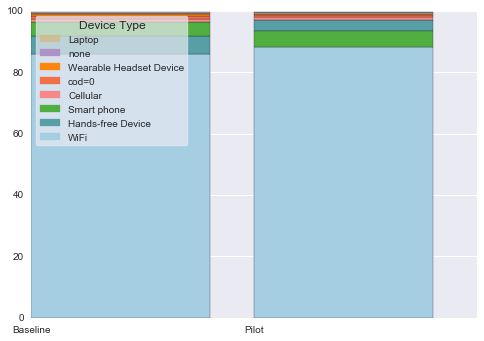

In [72]:
handles = []
periods = [1, 2]

for i, device_type in enumerate(king_devices["Device Type"].unique()):
    device_data = king_devices[king_devices["Device Type"] == device_type]
    plt.bar(periods, device_data["% of Observations"], bottom=device_data.bottom, color=colors[i])
    handles.append(mpl.patches.Patch(color=colors[i], label=device_type))
plt.xticks(periods, king_devices["period"].unique())
plt.legend(title="Device Type", handles=list(reversed(handles)), loc='upper left',
                 fancybox=True, framealpha=0.7, frameon=True)

In [3]:
sql = '''WITH king_pilot_segments AS (SELECT * FROM ( VALUES (1454340), (1454224), (1454352), (1454366), (1454181), (1454209), (1454378), (1454196) 
) AS v (analysis_id))

,three_months AS (SELECT 'Baseline' as period, cod, measured_timestamp::DATE as dt
FROM bluetooth.observations_201710
INNER JOIN king_pilot_segments USING (analysis_id)
WHERE EXTRACT('isodow' FROM measured_timestamp) < 6 AND device_class = 1
UNION ALL
SELECT CASE WHEN measured_timestamp <= '2017-11-08'::DATE THEN 'Baseline'
            WHEN measured_timestamp > '2017-11-12'::DATE THEN 'Pilot'
            ELSE 'Exclude' END AS period, cod, measured_timestamp::DATE as dt
FROM bluetooth.observations_201711
INNER JOIN king_pilot_segments USING (analysis_id)
WHERE  EXTRACT('isodow' FROM measured_timestamp) < 6 AND device_class = 1
UNION ALL
SELECT 'Pilot' as period, cod, measured_timestamp::DATE as dt
FROM bluetooth.observations_201712
INNER JOIN king_pilot_segments USING (analysis_id)
WHERE EXTRACT('isodow' FROM measured_timestamp) < 6 AND device_class = 1
)
, cnts AS(SELECT period, CASE WHEN cod = 0 THEN 'cod=0'
                              ELSE device_type END AS "Device Type", COUNT(1) AS "Num observations"
                     , COUNT(DISTINCT dt) as num_days
FROM three_months 
INNER JOIN bluetooth.class_of_device USING (cod)
WHERE period != 'Exclude'
GROUP BY period, "Device Type")
, tot AS (SELECT period, SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY period)
SELECT tot.period, "Device Type", 100.0*COALESCE(SUM("Num observations") OVER w, 0.0)/total_cnt as bottom, 
100.0*"Num observations"/total_cnt as "% of Observations", "Num observations"/num_days AS "Daily Observations"
FROM tot
JOIN LATERAL (SELECT period, "Device Type", "Num observations", num_days 
              FROM cnts c 
              WHERE tot.period = c.period
              ORDER BY "Num observations" DESC LIMIT 8
        )top_8 ON TRUE
WINDOW w AS (PARTITION BY tot.period ORDER BY "Num observations" DESC ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
'''

king_devices = pandasql.read_sql(sql, con)

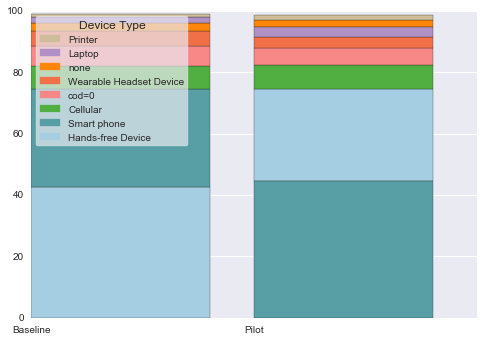

In [74]:
handles = []
periods = [1, 2]

for i, device_type in enumerate(king_devices["Device Type"].unique()):
    device_data = king_devices[king_devices["Device Type"] == device_type]
    plt.bar(periods, device_data["% of Observations"], bottom=device_data.bottom, color=colors[i])
    handles.append(mpl.patches.Patch(color=colors[i], label=device_type))
plt.xticks(periods, king_devices["period"].unique())
plt.legend(title="Device Type", handles=list(reversed(handles)), loc='upper left',
                 fancybox=True, framealpha=0.7, frameon=True)

In [7]:
pivoted = king_devices.pivot_table(index="Device Type", values=["Daily Observations"], columns='period')
pivoted = pivoted.reindex(pivoted['Daily Observations'].sort_values('Baseline', ascending=False).index)
pivoted

Daily Observations      
period                            Baseline Pilot
Device Type                                     
Hands-free Device                     1174   498
Smart phone                            877   747
Cellular                               208   132
cod=0                                  176    92
Wearable Headset Device                136    58
none                                    64    37
Laptop                                  54    54
Printer                                 26    30

In [8]:
pivoted['% Drop'] =  (pivoted['Daily Observations']['Pilot'] - pivoted['Daily Observations']['Baseline'])/pivoted['Daily Observations']['Baseline']
pivoted

Daily Observations          % Drop
period                            Baseline Pilot          
Device Type                                               
Hands-free Device                     1174   498 -0.575809
Smart phone                            877   747 -0.148233
Cellular                               208   132 -0.365385
cod=0                                  176    92 -0.477273
Wearable Headset Device                136    58 -0.573529
none                                    64    37 -0.421875
Laptop                                  54    54  0.000000
Printer                                 26    30  0.153846

Observations by all device types have dropped since the start of the pilot. There is a noticeable and dimensionally similar drop in "Hands-free Device" and "Wearable Headset Device" (and `cod=0` and `none`) daily observations. I would expect observations of these to be even lower, however, so the total number of daily observations is a little surprising.

## Conclusions

 1. Based on an analysis of speed distributions, `cod = 0` devices appear to be vehicles.
 2. Cellular and Smart phone device types have noticeably slower speed distributions, 
 3. Very short Blip segments have a similar "teleporting" problem, where short detection intervals between sensors result in impossibly fast travel times. Even when aggregated to 5-min bins, these observations appear a non-trivial amount of times, and not only in off-peak times.
 4. Speeds do not meaningfully change pre-post pilot
 4. Proportions of device types overall do not change in the King Pilot routes month-by-month